In [1]:
import setGPU

setGPU: Setting GPU to: 1


In [2]:
# limit GPU usage
import sys
import tensorflow as tf
gpuFraction = 0.2
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpuFraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
import keras
from keras import backend as K
K.set_session(sess)
print('using gpu memory fraction: '+str(gpuFraction))

Using TensorFlow backend.


using gpu memory fraction: 0.2


In [3]:
%matplotlib inline

In [4]:
import h5py
import glob
import numpy as np

In [7]:
# need afs password to read from eos
import os
import getpass
os.system("echo %s| kinit" %getpass.getpass())

········


0

## MERGE SOME Z(nunu)+jet file

In [10]:
features = np.array([])
truth = np.array([])
pfDelphes = np.array([])
raw = np.array([])
first = True
os.system("rm ../DATA/ZtoNuNu_lepFilter_13TeV_JetImage.h5")
for fileName in glob.glob("/eos/cms/store/cmst3/group/dehep/TOPGEN/Delphes/ZtoNuNu_lepFilter_13TeV/*13TeV*1*jetImage.h5"):
    if fileName.find("_SMEARED") != -1: continue
    # smeared file
    myFile = h5py.File(fileName)
    #mypfreco = myFile.get('jetMomenta')
    #pfDelphes = np.concatenate((pfDelphes,mypfreco), axis=0) if pfDelphes.size else mypfreco
    # unsmeared jet
    #myFile = h5py.File(fileName.replace("_SMEARED",""))
    mytruth = myFile.get('jetMomenta')
    myraw = myFile.get('rawJetMomenta')
    myfeatures = myFile.get('jetImages')    
    truth = np.concatenate((truth,mytruth), axis=0) if truth.size else mytruth
    raw = np.concatenate((raw,myraw), axis=0) if raw.size else myraw
    features = np.concatenate((features,myfeatures), axis=0) if features.size else myfeatures
#print(features.shape, truth.shape, raw.shape, pfDelphes.shape)
fileOut = h5py.File("../DATA/ZtoNuNu_lepFilter_13TeV_JetImage.h5", "w")
#fileOut.create_dataset('jetSmearedDelphes', data=pfDelphes,compression='gzip')
fileOut.create_dataset('jetMomenta', data=truth,compression='gzip')
fileOut.create_dataset('rawJetMomenta', data=raw,compression='gzip')
fileOut.create_dataset('jetImages', data=features,compression='gzip')
fileOut.close()

(3686, 20, 20, 2) (3686, 4) (3686, 4) (0,)
(7418, 20, 20, 2) (7418, 4) (7418, 4) (0,)
(11108, 20, 20, 2) (11108, 4) (11108, 4) (0,)
(14868, 20, 20, 2) (14868, 4) (14868, 4) (0,)
(18544, 20, 20, 2) (18544, 4) (18544, 4) (0,)
(22263, 20, 20, 2) (22263, 4) (22263, 4) (0,)
(25975, 20, 20, 2) (25975, 4) (25975, 4) (0,)
(29703, 20, 20, 2) (29703, 4) (29703, 4) (0,)
(33375, 20, 20, 2) (33375, 4) (33375, 4) (0,)
(37071, 20, 20, 2) (37071, 4) (37071, 4) (0,)
(40768, 20, 20, 2) (40768, 4) (40768, 4) (0,)
(44437, 20, 20, 2) (44437, 4) (44437, 4) (0,)
(48161, 20, 20, 2) (48161, 4) (48161, 4) (0,)
(51896, 20, 20, 2) (51896, 4) (51896, 4) (0,)
(55593, 20, 20, 2) (55593, 4) (55593, 4) (0,)
(59297, 20, 20, 2) (59297, 4) (59297, 4) (0,)
(62962, 20, 20, 2) (62962, 4) (62962, 4) (0,)
(66761, 20, 20, 2) (66761, 4) (66761, 4) (0,)
(70403, 20, 20, 2) (70403, 4) (70403, 4) (0,)
(74062, 20, 20, 2) (74062, 4) (74062, 4) (0,)
(77775, 20, 20, 2) (77775, 4) (77775, 4) (0,)
(81546, 20, 20, 2) (81546, 4) (81546, 4)

In [11]:
# delete datasets
del truth, raw, features
del mytruth, myraw, myfeatures

In [12]:
# open the new dataset
fileIn = h5py.File("../DATA/ZtoNuNu_lepFilter_13TeV_JetImage.h5")
#delphesPt = fileIn.get("jetSmearedDelphes")
truth = fileIn.get("jetMomenta")
raw = fileIn.get("rawJetMomenta")
features = fileIn.get("jetImages")

# show average image

In [13]:
sumImage = np.sum(features,axis=0)
print(sumImage.shape)

(20, 20, 2)


In [14]:
caloImage = sumImage[:,:,0]
trkImage = sumImage[:,:,1]

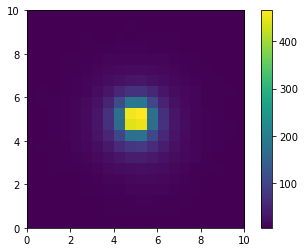

In [15]:
import matplotlib.pyplot as plt
plt.imshow(caloImage/caloImage.shape[0], extent=[0, 10, 0, 10], origin='lower')
plt.colorbar()

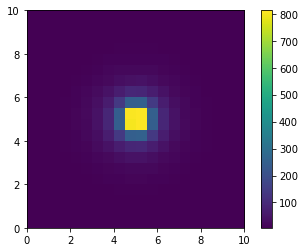

In [16]:
plt.imshow(trkImage/trkImage.shape[0], extent=[0, 10, 0, 10], origin='lower')
plt.colorbar()

# Prepare train and test samples



In [17]:
print(raw.shape)

(387204, 4)


In [18]:
from sklearn.preprocessing import MinMaxScaler
# normalize raw inputs and outputs between 0 and 1
scaler = MinMaxScaler()
print(scaler.fit(raw))
maxVal = scaler.data_max_
minVal = scaler.data_min_
raw = (raw-minVal)/(maxVal-minVal)
truth = (truth-minVal)/(maxVal-minVal)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [22]:
# we only care about the jet pT. So we forget about eta and phi
truth = truth[:,0]
truth = np.reshape(truth, (truth.shape[0], 1))
#delphesPt = delphesPt[:,0]
#delphesPt = np.reshape(delphesPt, (delphesPt.shape[0], 1))
#print(truth.shape, delphesPt.shape)
print(truth.shape)

(387204, 1)


In [23]:
iSplit = int(0.7*truth.shape[0])
x_image_train = features[:iSplit, :, :, :]
x_image_test = features[iSplit:, :, :, :]
x_raw_train = raw[:iSplit, :]
x_raw_test = raw[iSplit:, :]
y_train = truth[:iSplit, :]
y_test = truth[iSplit:, :]

In [24]:
print(x_image_train.shape)

(271042, 20, 20, 2)


In [25]:
x_image_test = np.reshape(x_image_test, (x_image_test.shape[0], x_image_test.shape[1],
                                         x_image_test.shape[2], x_image_test.shape[3], 1))
x_image_train = np.reshape(x_image_train, (x_image_train.shape[0], x_image_train.shape[1],
                                           x_image_train.shape[2], x_image_train.shape[3], 1))

In [26]:
print(x_raw_test.shape, x_raw_train.shape)

(116162, 4) (271042, 4)


# build the model

In [27]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Conv3D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling3D
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [28]:
batch_size = 128
img_rows, img_cols = 20, 20
nImages = 2

In [49]:
image_shape = (img_rows, img_cols, nImages, 1)
####
# this is the raw pT
InputRaw = Input(shape=(4,))
x2 = BatchNormalization()(InputRaw)
# this is the input image
inputImage = Input(shape=(image_shape))
x = BatchNormalization()(inputImage)
x = Conv3D(5, kernel_size=(3, 3, 2), data_format="channels_last", strides=(1, 1, 1), activation='relu', input_shape=image_shape)(x)
x = Dropout(0.25)(x)
#x = MaxPooling3D(pool_size=(2, 2, 1))(x)
# from 3D to 2D
print(x.shape)
x = Reshape((18, 18, 5), input_shape=(18, 18, 1, 5))(x)
x = Conv2D(1, kernel_size=(3, 3), activation='relu', input_shape=image_shape)(x)
x = Dropout(0.25)(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
dense = Concatenate(axis=1)([x, x2])
dense = Dense(10, activation='relu')(dense)
dense = Dropout(0.25)(dense)
output = Dense(1, activation='linear')(dense)
####
model = Model(input=(InputRaw,inputImage), output=output)

(?, 18, 18, 1, 5)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=(<tf.Tenso..., outputs=Tensor("de...)`


In [50]:
model.compile(loss='mse', optimizer='adam')
model.summary()
# plot graph
# plot_model(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 20, 20, 2, 1)  0                                            
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 20, 20, 2, 1)  4           input_4[0][0]                    
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 18, 18, 1, 5)  95          batch_normalization_4[0][0]      
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 18, 18, 1, 5)  0           conv3d_2[0][0]                   
___________________________________________________________________________________________

In [51]:
# train 
history = model.fit([x_raw_train, x_image_train], y_train, epochs=150, batch_size=batch_size, verbose = 2,
                validation_data=([x_raw_test, x_image_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 271042 samples, validate on 116162 samples
Epoch 1/150
28s - loss: 0.0114 - val_loss: 5.4845e-04
Epoch 2/150
28s - loss: 5.4932e-04 - val_loss: 4.1603e-04
Epoch 3/150
28s - loss: 3.9751e-04 - val_loss: 1.9565e-04
Epoch 4/150
28s - loss: 2.9752e-04 - val_loss: 1.6779e-04
Epoch 5/150
28s - loss: 2.4486e-04 - val_loss: 1.3904e-04
Epoch 6/150

Epoch 00005: reducing learning rate to 0.00010000000474974513.
28s - loss: 2.0480e-04 - val_loss: 1.2468e-04
Epoch 7/150
28s - loss: 1.8633e-04 - val_loss: 1.2057e-04
Epoch 8/150

Epoch 00007: reducing learning rate to 1.0000000474974514e-05.
28s - loss: 1.8128e-04 - val_loss: 1.1755e-04
Epoch 9/150
28s - loss: 1.8031e-04 - val_loss: 1.1839e-04
Epoch 10/150

Epoch 00009: reducing learning rate to 1.0000000656873453e-06.
28s - loss: 1.8106e-04 - val_loss: 1.1679e-04
Epoch 11/150
28s - loss: 1.7887e-04 - val_loss: 1.1827e-04
Epoch 12/150

Epoch 00011: reducing learning rate to 1.0000001111620805e-07.
28s - loss: 1.8035e-04 - val_loss: 1.1705e-

# Loss at early stop:
- Adam with mse: 
       Epoch 28/150 / loss: 8.5737e-05 - val_loss: 5.9542e-05
       CNN MEAN: -0.221108 / CNN RMS: 0.689300
       
- Adam with logcosh: 
        Epoch 40/150 / loss: 4.2010e-05 - val_loss: 2.3856e-05
        CNN MEAN: -0.225471 / CNN RMS: 0.590492

- Adadelta with mse: 
        Epoch 24/150 / loss: 9.2832e-05 - val_loss: 6.1209e-05
        CNN MEAN: -0.230359 CNN RMS: 0.685298


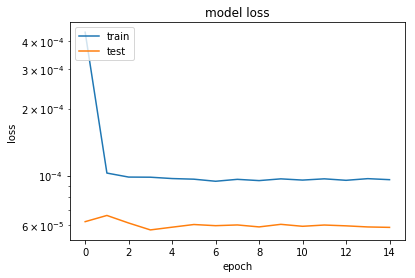

In [32]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#

In [33]:
ptPredict = model.predict([x_raw_test, x_image_test])
ptPredict = np.reshape(ptPredict, (ptPredict.shape[0],))

In [35]:
#put pT back in its range
#delphesPt = minVal[0] + np.reshape(delphesPt, (delphesPt.shape[0],))*(maxVal[0]-minVal[0])
pTraw = minVal[0] + x_raw_test[:,0]*(maxVal[0]-minVal[0])
pTreco = minVal[0] + np.reshape(y_test, (y_test.shape[0],))*(maxVal[0]-minVal[0])
ptPredict = minVal[0] + ptPredict*(maxVal[0]-minVal[0])

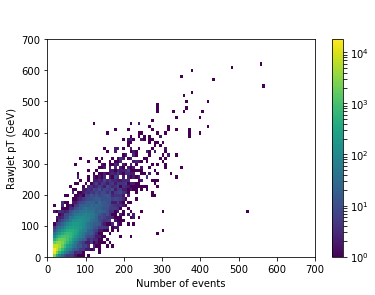

In [36]:
from matplotlib.colors import LogNorm
# pT resolution before regression
plt.hist2d(pTreco, pTraw, bins=80, norm=LogNorm())
plt.xlim((0.,700.))
plt.ylim((0.,700.))
plt.ylabel('RawJet pT (GeV)')
plt.xlabel('PFJet pT (GeV)')
plt.xlabel('Number of events')
plt.colorbar()
plt.show()

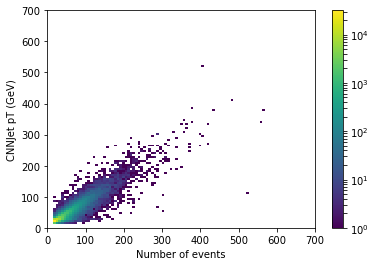

In [37]:
# pT resolution after regression
plt.hist2d(pTreco, ptPredict, bins=80, norm=LogNorm())
plt.xlim((0.,700.))
plt.ylim((0.,700.))
plt.ylabel('CNNJet pT (GeV)')
plt.xlabel('PFJet pT (GeV)')
plt.xlabel('Number of events')
plt.colorbar()
plt.show()

In [ ]:
## pT resolution @trigger from Delphes
#plt.hist2d(pTreco, delphesPt, bins=80, norm=LogNorm())
#plt.xlim((0.,700.))
#plt.ylim((0.,700.))
#plt.ylabel('Trigger PFJet pT (GeV)')
#plt.xlabel('PFJet pT (GeV)')
#plt.xlabel('Number of events')
#plt.colorbar()
#plt.show()

In [38]:
print(pTreco.shape, ptPredict.shape)

(116162,) (116162,)


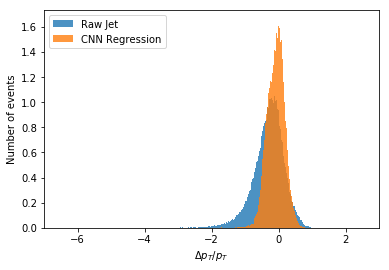

RAW MEAN: -0.298697
RAW RMS: 0.465952
-------------------
CNN MEAN: -0.079852
CNN RMS: 0.258184


In [40]:
plt.xlim(-7., 3.)
# histtype = 'step'
resRaw = np.nan_to_num((pTreco-pTraw)/pTreco)
resCNN = np.nan_to_num((pTreco-ptPredict)/pTreco)
#resDelphes = np.nan_to_num((pTreco-delphesPt)/pTreco)
plt.hist(resRaw, bins = 500, normed=1, alpha = 0.8)
plt.hist(resCNN, bins = 500, normed=1, alpha = 0.8)
#plt.hist(resDelphes, bins = 500, normed=1, alpha = 0.8)
plt.ylabel('Number of events')
plt.xlabel('$\Delta p_T/p_T$')
#plt.legend(['Raw Jet','CNN Regression', 'Trigger PFJet'], loc='upper left')
plt.legend(['Raw Jet','CNN Regression'], loc='upper left')
plt.show()
from scipy.stats import norm
(mu, sigma) = norm.fit(resRaw)
print("RAW MEAN: %f" %mu)
print("RAW RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(resCNN)
print("CNN MEAN: %f" %mu)
print("CNN RMS: %f" %sigma)
#(mu, sigma) = norm.fit(resDelphes)
#print("Trigger PFJet MEAN: %f" %mu)
#print("Trigger PFJet RMS: %f" %sigma)

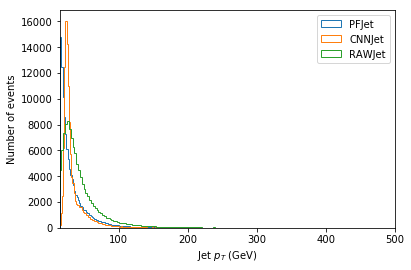

In [41]:
# plot pT spectra
plt.xlim(15., 500.)
countsDEN, binsDEN, barsDEN = plt.hist(pTreco, bins = 300, histtype = 'step')
countsNUM, binsNUM, barsNUM = plt.hist(ptPredict, bins = 300, histtype = 'step')
countsNUMRAW, binsNUMRAW, barsNUMRAW = plt.hist(pTraw, bins = 300, histtype = 'step')
#countsDelphes, binsDelphes, barsDelphes = plt.hist(delphesPt, bins = 300, histtype = 'step')
plt.ylabel('Number of events')
plt.xlabel('Jet $p_T$ (GeV)')
#plt.legend(['PFJet','CNNJet','RAWJet', 'Trigger PFJet'], loc='upper right')
plt.legend(['PFJet','CNNJet','RAWJet'], loc='upper right')
plt.show()

In [42]:
bins = np.array(binsNUM)
bins = bins+(bins[1]-bins[0])/2.
bins = bins[:-1]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:184: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:189: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


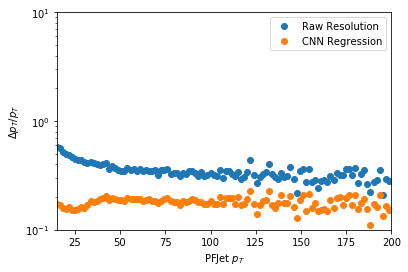

In [43]:
# build the profile plots for resolution vs pT [BY HAND!!!!]
binEdge = np.array(binsNUM)
meanRAW = []
errRAW = []
meanCNN = []
errCNN = []
for i in range(len(binEdge)-1):
    inBin = (pTreco >= binEdge[i]) * (pTreco < binEdge[i+1])
    populationRAW = resRaw[inBin]
    populationCNN = resCNN[inBin]
    #
    (mu, sigma) = norm.fit(populationRAW)
    meanRAW.append(mu)
    errRAW.append(sigma)
    #
    (mu, sigma) = norm.fit(populationCNN)
    meanCNN.append(mu)
    errCNN.append(sigma)
errRAW = np.array(errRAW)
errCNN = np.array(errCNN)
# resolution vs pT
plt.xlim(15., 200.)
# LOG SCALE
plt.yscale('log')
plt.ylim(0.1, 10.)
# LINEAR
#plt.ylim(0., 5.)
# histtype = 'step'
plt.plot(bins, errRAW,"o")
plt.plot(bins, errCNN, "o")
plt.ylabel('$\Delta p_T/p_T$')
plt.xlabel('PFJet $p_T$')
plt.legend(['Raw Resolution','CNN Regression', ], loc='upper right')
plt.show()

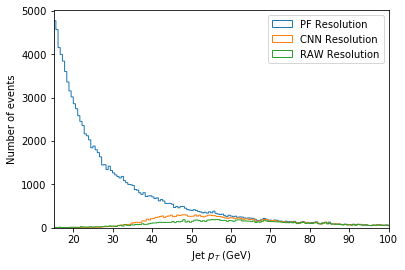

In [44]:
# now build ingredients to the turn-on curves
plt.xlim(15., 100.)
countsDEN, binsDEN, barsDEN = plt.hist(pTreco, bins = 1000, histtype = 'step')
countsNUM, binsNUM, barsNUM = plt.hist(pTreco[ptPredict>40.], bins = 1000, histtype = 'step')
countsNUMRAW, binsNUMRAW, barsNUMRAW = plt.hist(pTreco[pTraw>65.], bins = 1000, histtype = 'step')
plt.ylabel('Number of events')
plt.xlabel('Jet $p_T$ (GeV)')
plt.legend(['PF Resolution','CNN Resolution','RAW Resolution'], loc='upper right')
plt.show()

In [45]:
bins = np.array(binsNUM)
bins = bins+(bins[1]-bins[0])/2.
bins = bins[:-1]

In [46]:
countsNUM = np.array(countsNUM)
countsDEN = np.array(countsDEN)
countsNUMRAW = np.array(countsNUMRAW)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2309: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta


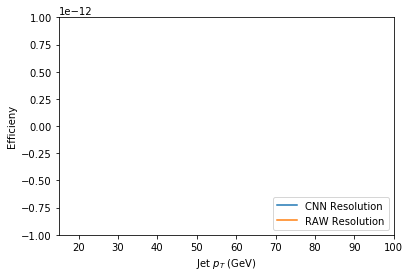

In [47]:
# build efficiencies 
eff_CNN = np.nan_to_num(countsNUM/countsDEN)
#err_CNN = np.nan_to_num(np.sqrt(eff_CNN*(1.-eff_CNN)/countsDEN))
#
eff_RAW = np.nan_to_num(countsNUMRAW/countsDEN)
#err_RAW = np.nan_to_num(np.sqrt(eff_RAW*(1.-eff_RAW)/countsDEN))
#
plt.xlim(15., 100.)
plt.plot(bins, eff_CNN)
plt.plot(bins, eff_RAW)
#
plt.ylabel('Efficieny')
plt.xlabel('Jet $p_T$ (GeV)')
plt.legend(['CNN Resolution','RAW Resolution'], loc='lower right')
plt.show()

In [ ]:
print(np.sum(ptPredict>40.)/len(pTreco))
print(np.sum(pTraw>65.)/len(pTreco))

In [ ]:
# to do: compare the result with what one gets from a Delphes reco with the same worsening of the resolution
# - 10% on photons
# - 20% on neutral hadrons
# - 15% on charged particles